# Introduction

## First day logistics

In [1]:
import os
os.system('make -C ../.. syllabus.html');

1. We look at the [syllabus](../../syllabus.html)

2. We introduce ourselves

**Toby Isaac (instructor):** CSE, Assistant Professor.  I do research and library development in

- High Performance Computing

- Numerical Methods for PDEs

- Inverse Problems and Uncertainty Quantification

Here are some of your research areas:

- Numerical solvers for data problems
- Bayesian inverse problem for hydrology
- Bayesian inverse problem theory for big problems
- " " Cosmology
- Training/infering contitutive relations
- Modeling chem. e. processes
- Transport MCMC
- Path reactor
- Chemical reaction
- Deep learning for healthcare
- Healthcare (adoption, etc.)
    

3. We choose office hours (whiteboard poll)

4. This is lunchtime.  If you can't eat before, just don't be distracting, and don't get us in trouble with facilities.

## What is this class all about

We have data $d$, and we want to make a prediction $p$ which we think is related.  What can we do?

- Suppose we believe there is a joint distribution $$(d,p) \sim \mathcal{D}(\Omega),$$ but $\mathcal{D}(\Omega)$ is unknown.  Suppose the data and the prediction are completely alien to us: we have just arrived on this planet.  If we are fortunate enough to have lots of samples $\{(d_i,p_i)\}_i$, then the explosion of data analysis and machine learning (so widespread that it is happening on our home planet, too) provides us with lots of tools, built on top of probability and statistics to help us approximate the conditional distribution of $$p | d.$$

- Data analysis and machine learning tools are not always enough on their own.  Common issues:
    * We do not have enough direct observations $\{(d_i,p_i)\}_i$ to train a model with any sort of confidence.
    * The correlations that we do have are in one regime, and we are presented with $d$ that looks like none of the $\{d_i\}$ we have seen before.
    * The training / evaluation of black-box methods is slow/expensive.  There has to be a better way!
    

- We are not, in fact, aliens who have just arrived on this planet (verified when you discussed your research areas earlier).  We can compensate for a lack of data, and better or more rapidly train a predictor by bringing to bear all of the data at our disposal.

**Example:** My data $d$ is the height at which I drop this marker [brandish marker], and my prediction $p$ is
how long until it hits the ground.  Make a prediction before I have gathered any $(d,p)$ pairs to train.

In [2]:
def predictor(d):
    g = 9.81
    return (2. * d / g)**0.5

In [3]:
predictor(1.3)

0.5148161593032162

Luckily, machine learning researchers in the past (previously known as "scientists") have trained network layers (aka "conducted research"), which I can use in my model! [The machine learning boom is so widespread, it is stretching into the past!]

(I apologize for the facetious tone of the preceding.  The truth is, machine learning *has* revolutionized the way we practice making predictions from data in some ways, for some problems.  Machine learning experts are well aware that their research fits into the continuity of scientific and mathematical progress and do not oversell the breadth or novelty of their work.  The pop-sci press, on the other hand...)

The takeaway from the preceding example is that for many problems of scientific interest, we benefit from **models that augment the data.**

A few other points belaboring this simple model:

- The model has a parameter ($g$, the acceleration due to gravity).  If you are lucky, your model will comprise only parameters that you can measure directly or derive values for.  One of the widest occuring types of inverse problem is *parameter estimation*.  Our shorthand for a parameterized model that produces outputs that can be compared to data will be $$F(m) \to d.$$ (Sometimes we may have different names for variables, like the model parameters being $p$ or $x$, often because we will have to make our notation mesh with established notation in various applications [like using $g$ for acceleration due to gravity].)

- Suppose we didn't have the benefit of high school physics to tell us $g= 9.8 m/s^2.$  We could perform a few experiments to try to determine its value.  (In this case, the heigh at which it drops, and the time the marker falls becomes the data in the $F(m)\to d$ notation.)

**Example:** suppose we measure $0.5$ seconds for the marker to fall one meter.  What is $g$?  If our timing is *exact* then we can know $g$ exactly.  Unfortunately, no measurement can be trusted completely (especially if we're measuring the time it takes for a marker to fall with a smartphone timer).

In [4]:
def predictor_with_noise(h):
    from numpy.random import rand
    
    blink = 0.1 # reaction time
    timer_start = blink * rand()
    g = 9.81
    fall_end = (2. * h / g)**0.5
    timer_end = fall_end + blink * rand()
    return timer_end - timer_start

In [7]:
predictor_with_noise(1.5)

0.4912646441108418

Suppose we have no knowledge of $g$ in `predictor` and we are trying to estimate it from values gathered
with `predictor_with_noise`.  Our shorthand for a model with uncertainty (which can be more than just noise) is
$$F(m) + e \to d.$$  In this class, evaluating/computing/simulating $F(m)[+ e]\to d$ is called **forward modeling**. 
Computing $"F^{-1}"(d - e) \to m$ is **inverse modeling**.

Anytime we have only finitely many evaluations of `predictor_with_noise` (which is everytime), we will be unable to constrain $g$ exactly.  If the value of $g$ is important (even *critical*) in the real world, we don't want mislead anyone into trusting our prediction of $g$ any more than is warranted.  It is often useful, then to try to **quantify our uncertainty** in $g$.  In this simple case, the two most common ways to express our uncertainty in $g$ are by:

- error bars ($g = 9 \pm 1.1$)
- as a parameter distribution ($g \sim \mathcal{N}(\mu = 9, \sigma = 1)$)

These two approaches correspond roughly to [frequentist](https://en.wikipedia.org/wiki/Frequentist_inference)
and [Bayesian](https://en.wikipedia.org/wiki/Bayesian_inference) inference.  These are just the two most famous inference frameworks that try to describe the extent to which we learn in the presence of uncertainty.  For our very simple single-parameter model, they end up reaching more or less the same conclusion from the same data.  For more complicated models with numerous parameters, that will not be the case.  We will have to evaluate
statistical frameworks based on how powerful/rigorous their inference are, as well as how practical it is to compute with them (i.e., both the cost of solving the inverse problem [aka infering or training the parameters], and using the model once established) as everything gets bigger (the number of parameters, the number/size of observations, the complexity of the models.)  Although the main focus of this class in inverse uncertainty quantification, efficiently making predictions with large statistical models (aka *forward uncertainty quantification*) will also be covered some.

- Suppose that not only the coefficient $g$, but the exponent $p$ in $(2 h / g)^p$ is uncertain in `predictor`.  If we have only one measurement of `predictor_with_noise`, then no matter how fast our reaction time, there will be
many possible parameterizations (choices of $g$ and $p$) that match the observations.  This means that **the inverse problem is ill-posed**.  For us in this room, it is not expensive to gather additional observations
to constrain a two parameter model.  For real world problems, however ill-posedness of the inverse problem is the generic case.  We need strategies for dealing with ill-posedness (either choosing a process for making an ill-posed problem well-posed to get a single solution, or conveying the uncertainty ill-posedness entails).  Furthermore, the world is not split into well-posed and ill-posed problems: there are gradations in between of **ill-conditioned** problems, the subject of our [first notebook](../conditioning/conditioning.ipynb).

[A couple more points raised by my former advisor Georg Stadler in the notes I put in [canvas](https://gatech.instructure.com/courses/70924/files?preview=2689505):

- Forward problems are *causal*: we have parameters precisely because their values affect
the model in predictable(ish) ways, and if the simulation happens to be time dependent, the future does not affect the past.  Inverse problems rarely have a nice way to track cause and effect.
- Forward problems are *local*: models often simulate physical processes of things in proximity interacting,
and computing $d$ from $m$ can be done in a sequence of proximal operations.
Inverse problems are usually *global*: getting $m$ from to $d$ may not have any locality to exploit.]

- If you do not remember high school physics, I have some bad news for you: our model `predictor` is wrong.  It does not include, e.g.:
    * wind resistance
    * elastic deformation of the marker
    * relativistic gravitation
    * surface chemistry
    
High-accuracy simulation of falling things is quite complicated, particularly if it is important that
the thing not [burn up](http://users.ices.utexas.edu/~roystgnr/aiaa_sensitivity_talk.pdf) in the atmosphere.
Say it with me now:

> All models are wrong but some are useful.

Sometimes the failure of a model can be looked at as just another "noise" that gets added to a "real" process,
$$F(m) + e_{noise} + e_{model} \to d.$$  But models are also

  * **biased**
  * **inadequate**
    
We will discuss strategies for compensating for these shortcomings.

- We also discuss situations with more than one model $F_A$ and $F_B$ and how to combine their predictions.  Many disciplines will have a "ground truth" model $F_h$ (small $h$ means this is a fine-scale model) that is expensive to evaluate and $F_H$ (large $H$ means this is a coarse-scale model) that is cheap to evaluate but inaccurate/biased/inadequate.  When is having $F_h$ and $F_H$ better than having just one or the other?

## A slightly more complex example

The Laplacian $\Delta u = \partial_x^2 u + \partial_y^2 u$ shows up in a lot of forward models.  It describes, diffusive, blurring processes that act on the **state** $u$: our simulation stand in for the real thing
that can be measured to get observations/data.  Suppose we observe, in some region of $\mathbb{R}^2$, some state that undergoes some blurring and noise,
$$d = u + \alpha \Delta u + e.$$ We could make our forward model the blurring operator ($F(u) = u + \Delta u$), and it agrees with what we have said above: applying $F$ is a local and causal procedure that can be numerically approximated using an approach to discretizing PDEs, like the finite element method.

[fenics](fenicsproject.org) is one popular tool for discretizing PDEs.

In [8]:
from fenics import *

It let's us set up a domain in $\mathbb{R}^2$ (or $\mathbb{R}^3$):

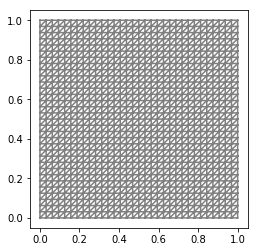

In [9]:
%matplotlib inline
mesh = UnitSquareMesh(32,32)
plot(mesh)

Define our state space $V$ that $u$ belongs to (which, in this simple example, is also our parameter space):

In [10]:
V = FunctionSpace(mesh, 'P', 1)

Initialize $u$:

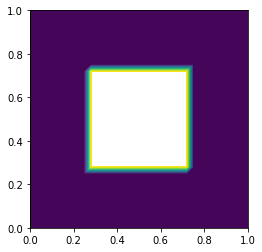

In [11]:
%matplotlib inline
u = interpolate(Expression('0.0 + (fabs(x[0] - 0.5) < 0.25)*(fabs(x[1] - 0.5) < 0.25)', degree = 1), V)
plot(u)

We define $F(u)$ (in a modified weak setting: this is a PDE detail that we won't go into today):

In [16]:
def F(u):
    from numpy.random import randn
    alpha = 1.e-3
    epsilon = 1.e-1

    v = TestFunction(V)
    w = TrialFunction(V)
    d = Function(V)
    F = (inner(grad(u),grad(v)) * alpha + u * v) * dx
    M = w * v * dx
    solve(M == F, d)
    n = d.vector().size()
    d.vector()[:] += epsilon * randn(n)
    return d

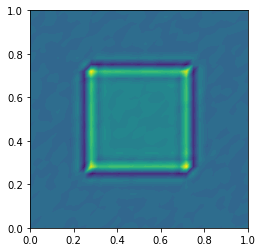

In [17]:
plot(F(u))

How well do we think we can recover $u$ from $d$?  How does that depend on $\alpha$ and $\epsilon$?

Do you see how we have $F_h$ and $F_H$ (in fact, many choices for $F$) in this case?

[Prof. Stadler's [notes](https://gatech.instructure.com/courses/70924/files?preview=2689505) include more (and more realistic) examples of inverse problems]

[My intention is for us to have space at PACE where you can run these notebooks and test out all of the numerical tools as well.  More details on that to follow.]

## Choose your own

I think that there is a good chance we may not have enough class time to fully explore all of the issues raised by our falling marker.  There are certain highlights within the material that I feel like I would be cheating you if we did not cover them.  But, especially as this is my first time trying this class, I want to make sure there is space for digression to pursue aspects of IUQ that are of interest and relevance to you.

- If we choose to go off on a tangent, I will need help.  I would love if students would share an aspect of their research related to class topics (either presenting, preparing notes ahead of time, contributing code to the repo that we can all try out).  It will not be *necessary* for your participation grade (not even expected!), but it will definitely be *sufficient*.